In [1]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

Fontconfig warning: ignoring UTF-8: not a valid region tag


In [2]:
class AR(keras.layers.Layer):
    def __init__(self, k = 1):
        super(AR, self).__init__() #AR es subclase de layer
        self.k = k # k = lags
        
    #input_shape = n_samples*length*channels
    def build(self, input_shape):
        self.phi = self.add_weight(
            shape = (1,self.k,1),
            initializer="random_normal",
            trainable=True,
        )
        self.sigma = self.add_weight(
            shape = (1,1),
            initializer= tf.keras.initializers.RandomNormal(mean = 0.0, stddev = 0.1),
            trainable=True,
        )
        
    def call(self, inputs):
        #inputs es de n*l*c
        #begin es un arreglo (tensor) de tamaño n*l*c también y se inicializa en [0,0,1] para empezar desde 
        #y se toma -1 para agarrar todos los samples, k para predecir usando k lengths y 
        x_slice = tf.slice(inputs, begin = [0,0,1], size = [-1, self.k,1]) #rebana el tensor. Es de tamaño N*K*1
        #Con el el slice estamos tomando solo la dim de al medio para predecir.
        pred = tf.multiply(x_slice, self.phi) + self.sigma
        pred = tf.reduce_sum(pred, 1)
        return pred

In [5]:
# fake_lcs = tf.ones([20,10,3])
# model = AR(k = 3)
# model(fake_lcs)

In [68]:
class ARIMA(tf.keras.Model):

    def __init__(self, p = 1,d = 0,q = 1):
        super(ARIMA, self).__init__()
        self.ar = AR(k = p)
        self.ma = None # AQUI DEBEN INICIALIZAR EL MA
        
        self.p = p
        self.q = q
        self.d = d
        
    def call(self, inputs): #Aquí el call recibe el tensor de N por L por C
        x_to_predict = tf.slice(inputs, [0, 0, 0], [-1, tf.shape(inputs)[1]-1, -1])
        
        def compute(i, out):
            x_slice = tf.slice(x_to_predict, 
                               begin = [0, i, 0], 
                               size = [-1, self.p, -1])
            x_pred = self.ar(x_slice)
            return tf.add(i, 1), out.write(i, x_pred)
    
        time_steps = tf.shape(x_to_predict)[1]+1
        
        # esto es como un for pero en GPU
        _, out = tf.while_loop(
            lambda a, b: a < time_steps-self.p,
            compute, # esta es la funcion que ejecutamos dentro del loop
            (tf.constant(0), tf.TensorArray(tf.float32, time_steps-self.p))
        )
        output_ar = tf.transpose(out.stack(), [1,0,2])
        # ==== MA =====        
        labels = tf.slice(inputs, [0, self.p, 1], [-1, -1, 1])
        print(output_ar.shape)
        print(labels.shape)
        return output_ar
    
    def train_step(self, data):
        # Unpack the data. Its structure depends on your model and
        # on what you pass to `fit()`.
        x, y = data
        
        
        with tf.GradientTape() as tape:
            y_pred = self(x, training=True)  # Forward pass
            print(y_pred.shape)
            # Compute the loss value
            # (the loss function is configured in `compile()`)
            loss = self.compiled_loss(y, y_pred, regularization_losses=self.losses)

        # Compute gradients
        trainable_vars = self.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)
        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))
        # Update metrics (includes the metric that tracks the loss)
        self.compiled_metrics.update_state(y, y_pred)
        # Return a dict mapping metric names to current value
        return {m.name: m.result() for m in self.metrics}
    

In [69]:
data = [] 

number_of_samples = 40
time_serie_length = 12

for i in range(number_of_samples):
    indices = tf.sort(tf.random.uniform([2], 0, 1000))
    
    times = tf.linspace(indices[0], indices[1], time_serie_length)
    values = tf.cast(tf.math.sin(times), tf.float32)
    
    errors = tf.cast(tf.ones_like(times), tf.float32)
    agregar = tf.stack([times, values, errors], axis = 1)
    data.append(agregar)

In [70]:
x = tf.stack(data, axis = 0)

In [71]:
lag      = 3
x_train = x
y_train = x[:,lag:, 1]
y_times = x[:,lag:, 0]
print(y_train.shape, x_train.shape)

(40, 9) (40, 12, 3)


In [72]:
# Esto es para debuggear
toy_model = ARIMA(p=2)
_ = toy_model(x_train)

(40, 10, 1)
(40, 10, 1)


tf.Tensor(12, shape=(), dtype=int32)


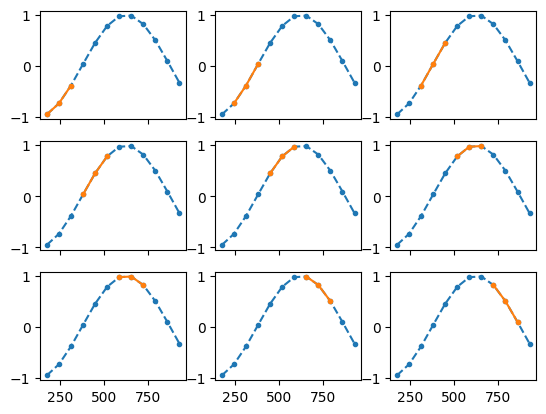

In [73]:
fig, axes = plt.subplots(3, 3, sharex=True)

time_steps = tf.shape(x_train)[1] 
print(time_steps)
for ax, i in zip(axes.flatten(), np.arange(time_steps-lag)):
#     print(i, i+lag)  
    x_slice = tf.slice(x_train, 
                       begin = [0, i, 0], 
                       size = [-1, lag, -1])
    
    ax.plot(x_train[0, :, 0], x_train[0, :, 1], linestyle='--', marker='.')
    ax.plot(x_slice[0, :, 0], x_slice[0, :, 1], marker='.')


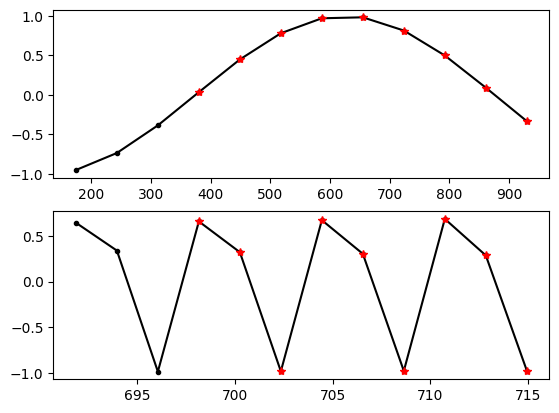

In [74]:
fig, axes = plt.subplots(2, 1)
for i in range(2):
    axes[i].plot(x_train[i, :, 0], x_train[i, :, 1], marker='.', label='input', linestyle='-', color='k')
    axes[i].plot(y_times[i, :], y_train[i, :], marker='*', label='to_pred', linestyle='', color='r')
    

In [75]:
model = ARIMA(p=lag,q=1,d=1)
opt = tf.keras.optimizers.experimental.SGD(1e-3)
model.compile(optimizer = opt, loss = 'mse', metrics = 'mse')
history = model.fit(x_train, y_train, epochs = 1000, batch_size=10)

Epoch 1/1000
(10, None, 1)
(10, 9, 1)
(10, None, 1)
(10, None, 1)
(10, 9, 1)
(10, None, 1)
4/4 [==============================] - 0s 2ms/step - loss: 0.7729 - mse: 0.7729
Epoch 2/1000
4/4 [==============================] - 0s 3ms/step - loss: 0.7377 - mse: 0.7377
Epoch 3/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.7075 - mse: 0.7075
Epoch 4/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.6812 - mse: 0.6812
Epoch 5/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.6585 - mse: 0.6585
Epoch 6/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.6389 - mse: 0.6389
Epoch 7/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.6220 - mse: 0.6220
Epoch 8/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.6073 - mse: 0.6073
Epoch 9/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.5947 - mse: 0.5947
Epoch 10/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.5837 - mse

4/4 [==============================] - 0s 2ms/step - loss: 0.5117 - mse: 0.5117
Epoch 88/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.5117 - mse: 0.5117
Epoch 89/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.5116 - mse: 0.5116
Epoch 90/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.5116 - mse: 0.5116
Epoch 91/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.5116 - mse: 0.5116
Epoch 92/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.5115 - mse: 0.5115
Epoch 93/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.5115 - mse: 0.5115
Epoch 94/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.5115 - mse: 0.5115
Epoch 95/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.5115 - mse: 0.5115
Epoch 96/1000
4/4 [==============================] - 0s 3ms/step - loss: 0.5115 - mse: 0.5115
Epoch 97/1000
4/4 [==============================] - 0s 2ms/step - loss: 0

4/4 [==============================] - 0s 2ms/step - loss: 0.5105 - mse: 0.5105
Epoch 174/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.5105 - mse: 0.5105
Epoch 175/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.5104 - mse: 0.5104
Epoch 176/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.5105 - mse: 0.5105
Epoch 177/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.5105 - mse: 0.5105
Epoch 178/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.5104 - mse: 0.5104
Epoch 179/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.5104 - mse: 0.5104
Epoch 180/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.5104 - mse: 0.5104
Epoch 181/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.5105 - mse: 0.5105
Epoch 182/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.5104 - mse: 0.5104
Epoch 183/1000
4/4 [==============================] - 0s 3ms/step

4/4 [==============================] - 0s 3ms/step - loss: 0.5099 - mse: 0.5099
Epoch 260/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.5098 - mse: 0.5098
Epoch 261/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.5099 - mse: 0.5099
Epoch 262/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.5099 - mse: 0.5099
Epoch 263/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.5099 - mse: 0.5099
Epoch 264/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.5100 - mse: 0.5100
Epoch 265/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.5099 - mse: 0.5099
Epoch 266/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.5099 - mse: 0.5099
Epoch 267/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.5099 - mse: 0.5099
Epoch 268/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.5100 - mse: 0.5100
Epoch 269/1000
4/4 [==============================] - 0s 2ms/step

4/4 [==============================] - 0s 2ms/step - loss: 0.5097 - mse: 0.5097
Epoch 346/1000
4/4 [==============================] - 0s 3ms/step - loss: 0.5097 - mse: 0.5097
Epoch 347/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.5096 - mse: 0.5096
Epoch 348/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.5097 - mse: 0.5097
Epoch 349/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.5097 - mse: 0.5097
Epoch 350/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.5098 - mse: 0.5098
Epoch 351/1000
4/4 [==============================] - 0s 3ms/step - loss: 0.5096 - mse: 0.5096
Epoch 352/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.5096 - mse: 0.5096
Epoch 353/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.5096 - mse: 0.5096
Epoch 354/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.5096 - mse: 0.5096
Epoch 355/1000
4/4 [==============================] - 0s 2ms/step

4/4 [==============================] - 0s 2ms/step - loss: 0.5094 - mse: 0.5094
Epoch 432/1000
4/4 [==============================] - 0s 3ms/step - loss: 0.5096 - mse: 0.5096
Epoch 433/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.5094 - mse: 0.5094
Epoch 434/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.5095 - mse: 0.5095
Epoch 435/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.5097 - mse: 0.5097
Epoch 436/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.5094 - mse: 0.5094
Epoch 437/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.5094 - mse: 0.5094
Epoch 438/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.5095 - mse: 0.5095
Epoch 439/1000
4/4 [==============================] - 0s 3ms/step - loss: 0.5095 - mse: 0.5095
Epoch 440/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.5097 - mse: 0.5097
Epoch 441/1000
4/4 [==============================] - 0s 2ms/step

4/4 [==============================] - 0s 2ms/step - loss: 0.5095 - mse: 0.5095
Epoch 518/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.5095 - mse: 0.5095
Epoch 519/1000
4/4 [==============================] - 0s 3ms/step - loss: 0.5095 - mse: 0.5095
Epoch 520/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.5096 - mse: 0.5096
Epoch 521/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.5097 - mse: 0.5097
Epoch 522/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.5094 - mse: 0.5094
Epoch 523/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.5094 - mse: 0.5094
Epoch 524/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.5095 - mse: 0.5095
Epoch 525/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.5094 - mse: 0.5094
Epoch 526/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.5095 - mse: 0.5095
Epoch 527/1000
4/4 [==============================] - 0s 3ms/step

4/4 [==============================] - 0s 2ms/step - loss: 0.5096 - mse: 0.5096
Epoch 604/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.5094 - mse: 0.5094
Epoch 605/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.5095 - mse: 0.5095
Epoch 606/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.5095 - mse: 0.5095
Epoch 607/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.5094 - mse: 0.5094
Epoch 608/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.5094 - mse: 0.5094
Epoch 609/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.5094 - mse: 0.5094
Epoch 610/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.5094 - mse: 0.5094
Epoch 611/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.5095 - mse: 0.5095
Epoch 612/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.5094 - mse: 0.5094
Epoch 613/1000
4/4 [==============================] - 0s 2ms/step

4/4 [==============================] - 0s 2ms/step - loss: 0.5094 - mse: 0.5094
Epoch 690/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.5094 - mse: 0.5094
Epoch 691/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.5094 - mse: 0.5094
Epoch 692/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.5094 - mse: 0.5094
Epoch 693/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.5094 - mse: 0.5094
Epoch 694/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.5094 - mse: 0.5094
Epoch 695/1000
4/4 [==============================] - 0s 3ms/step - loss: 0.5097 - mse: 0.5097
Epoch 696/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.5096 - mse: 0.5096
Epoch 697/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.5094 - mse: 0.5094
Epoch 698/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.5095 - mse: 0.5095
Epoch 699/1000
4/4 [==============================] - 0s 2ms/step

4/4 [==============================] - 0s 5ms/step - loss: 0.5094 - mse: 0.5094
Epoch 776/1000
4/4 [==============================] - 0s 6ms/step - loss: 0.5094 - mse: 0.5094
Epoch 777/1000
4/4 [==============================] - 0s 5ms/step - loss: 0.5093 - mse: 0.5093
Epoch 778/1000
4/4 [==============================] - 0s 5ms/step - loss: 0.5094 - mse: 0.5094
Epoch 779/1000
4/4 [==============================] - 0s 5ms/step - loss: 0.5094 - mse: 0.5094
Epoch 780/1000
4/4 [==============================] - 0s 5ms/step - loss: 0.5094 - mse: 0.5094
Epoch 781/1000
4/4 [==============================] - 0s 5ms/step - loss: 0.5094 - mse: 0.5094
Epoch 782/1000
4/4 [==============================] - 0s 4ms/step - loss: 0.5093 - mse: 0.5093
Epoch 783/1000
4/4 [==============================] - 0s 5ms/step - loss: 0.5094 - mse: 0.5094
Epoch 784/1000
4/4 [==============================] - 0s 5ms/step - loss: 0.5094 - mse: 0.5094
Epoch 785/1000
4/4 [==============================] - 0s 5ms/step

4/4 [==============================] - 0s 4ms/step - loss: 0.5094 - mse: 0.5094
Epoch 862/1000
4/4 [==============================] - 0s 4ms/step - loss: 0.5093 - mse: 0.5093
Epoch 863/1000
4/4 [==============================] - 0s 4ms/step - loss: 0.5094 - mse: 0.5094
Epoch 864/1000
4/4 [==============================] - 0s 4ms/step - loss: 0.5095 - mse: 0.5095
Epoch 865/1000
4/4 [==============================] - 0s 4ms/step - loss: 0.5093 - mse: 0.5093
Epoch 866/1000
4/4 [==============================] - 0s 5ms/step - loss: 0.5095 - mse: 0.5095
Epoch 867/1000
4/4 [==============================] - 0s 6ms/step - loss: 0.5094 - mse: 0.5094
Epoch 868/1000
4/4 [==============================] - 0s 4ms/step - loss: 0.5093 - mse: 0.5093
Epoch 869/1000
4/4 [==============================] - 0s 4ms/step - loss: 0.5093 - mse: 0.5093
Epoch 870/1000
4/4 [==============================] - 0s 4ms/step - loss: 0.5093 - mse: 0.5093
Epoch 871/1000
4/4 [==============================] - 0s 8ms/step

4/4 [==============================] - 0s 4ms/step - loss: 0.5094 - mse: 0.5094
Epoch 948/1000
4/4 [==============================] - 0s 5ms/step - loss: 0.5094 - mse: 0.5094
Epoch 949/1000
4/4 [==============================] - 0s 4ms/step - loss: 0.5094 - mse: 0.5094
Epoch 950/1000
4/4 [==============================] - 0s 4ms/step - loss: 0.5094 - mse: 0.5094
Epoch 951/1000
4/4 [==============================] - 0s 4ms/step - loss: 0.5094 - mse: 0.5094
Epoch 952/1000
4/4 [==============================] - 0s 3ms/step - loss: 0.5093 - mse: 0.5093
Epoch 953/1000
4/4 [==============================] - 0s 4ms/step - loss: 0.5096 - mse: 0.5096
Epoch 954/1000
4/4 [==============================] - 0s 4ms/step - loss: 0.5095 - mse: 0.5095
Epoch 955/1000
4/4 [==============================] - 0s 4ms/step - loss: 0.5094 - mse: 0.5094
Epoch 956/1000
4/4 [==============================] - 0s 3ms/step - loss: 0.5094 - mse: 0.5094
Epoch 957/1000
4/4 [==============================] - 0s 5ms/step

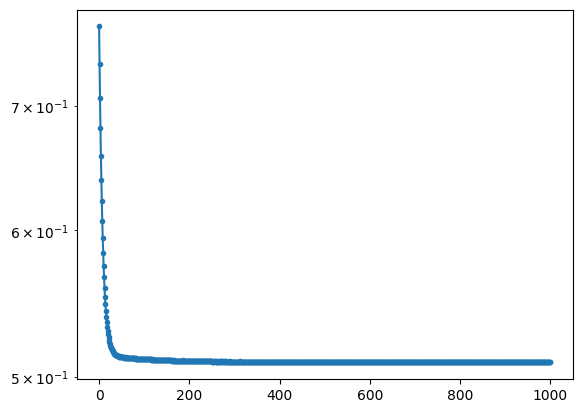

In [76]:
plt.plot(history.history['loss'], marker='.')
plt.yscale('log')

In [77]:
y_pred = model.predict(x_train)

(None, None, 1)
(None, 9, 1)
2/2 [==============================] - 0s 2ms/step


In [78]:
y_pred.shape

(40, 9, 1)

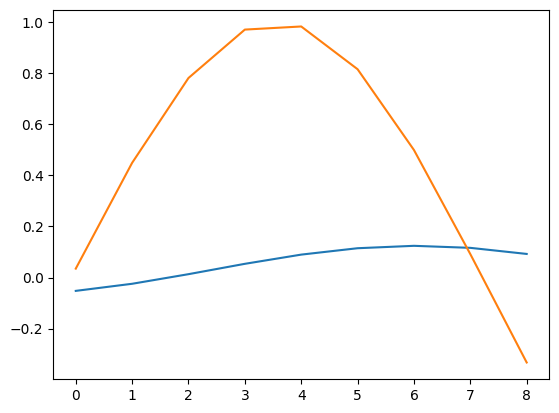

In [79]:
plt.plot(y_pred[0])
plt.plot(y_train[0])